In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import scipy.io
import time

In [2]:
# Lets read our CFD results of lift-drag ratio data containing for different airfoils

data = scipy.io.loadmat('../input/data-mat/1_300.mat')

In [3]:
# Seperating X, y values from the dictionary
X, y, rNorm = data['data_x'], data['data_y'], data['Normalization_Factor']

In [4]:
# Checking the sape of the X value
X.shape

(6855, 16384)

so we have 6855 examples and flattened 128-by-128 image vector <br>
we can look one of the image from our dataset below

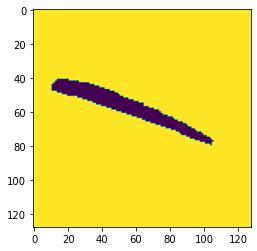

In [5]:
plt.imshow(X.reshape(-1,128,128)[17])
plt.show()

In [6]:
# Checking the shape of the X value
y.shape

(6855, 1)

we have one lift-drag ratio value for each example

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [9]:
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.9, random_state=47)

In [10]:
print(f'Shape of Train data: {X_train.shape} \n')
print(f'Shape of Validation data: {X_val.shape} \n')
print(f'Shape of Test data: {X_test.shape}')

Shape of Train data: (5244, 16384) 

Shape of Validation data: (582, 16384) 

Shape of Test data: (1029, 16384)


In [11]:
X_train = X_train.reshape(-1,128,128,1)
X_val = X_val.reshape(-1,128,128,1)

In [12]:
# Lets define our image shape
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 1

In [13]:
#set up parameters
batch_size = 32
learning_rate = 1e-5
num_epochs = 50

In [14]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as k

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization, Concatenate

In [15]:
#model = Sequential()

#model.add(Input(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
#model.add(Conv2D(5, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization(axis=3))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization(axis=3))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization(axis=3))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization(axis=3))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

In [16]:
inputs = Input((IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1) 
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = Concatenate(axis = 3)([drop4,up6])
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = Concatenate(axis = 3)([conv3,up7])
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = Concatenate(axis = 3)([conv2,up8])
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = Concatenate(axis = 3)([conv1,up9])
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

flat = Flatten()(conv9)

conv10 = Dense(1, activation = 'sigmoid')(flat)



In [17]:
model = Model(inputs = inputs , outputs = conv10)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [20]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),  #SGD(lr=0.005, momentum=0.9), #Adam(learning_rate = 2e-4),
                        loss = tf.keras.losses.MSE, #'categorical_crossentropy'
                        metrics = ['mse']) #'acc'

In [21]:
# Stop training when the val_loss has stopped decreasing for 5 epochs.
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                       restore_best_weights=True, verbose=1)

In [22]:
STEP_SIZE_TRAIN = len(X_train)//batch_size
STEP_SIZE_VALID = len(X_val)//batch_size

In [23]:
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.3,
                                  patience = 3,
                                  min_lr = 1e-8,
                                  mode = 'min',
                                  verbose = 1)

# Save the model with the minimum validation loss
checkpoint_cb = ModelCheckpoint("./best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
history = model.fit(x=X_train,y=y_train, validation_data=(X_val,y_val), 
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks=[es, reduce_lr],
                    batch_size= batch_size,epochs= num_epochs)

Epoch 1/50
163/163 [==============================] - 50s 269ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 2/50
163/163 [==============================] - 45s 265ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 3/50
163/163 [==============================] - 43s 264ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/50
163/163 [==============================] - 43s 264ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 5/50
163/163 [==============================] - 43s 264ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 6/50
163/163 [==============================] - 43s 264ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/50
163/163 [==============================] - 43s 264ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 8/50
163/163 [==============================] - 4

In [24]:
y_pred = model.predict(X_test.reshape(-1,128,128,1))
y_pred.shape

(1029, 1)

In [25]:
y_test.shape

(1029, 1)

In [26]:
y_pred

array([[0.13586567],
       [0.18700768],
       [0.03278466],
       ...,
       [0.09403549],
       [0.13799205],
       [0.20296617]], dtype=float32)

In [27]:
y_test

array([[0.09888653],
       [0.18745521],
       [0.00974133],
       ...,
       [0.09375846],
       [0.07944649],
       [0.240902  ]])

In [28]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, r2_score

In [29]:
r2_score(y_test,y_pred)

0.8167562859458307

ValueError: x and y must have same first dimension, but have shapes (1,) and (43,)

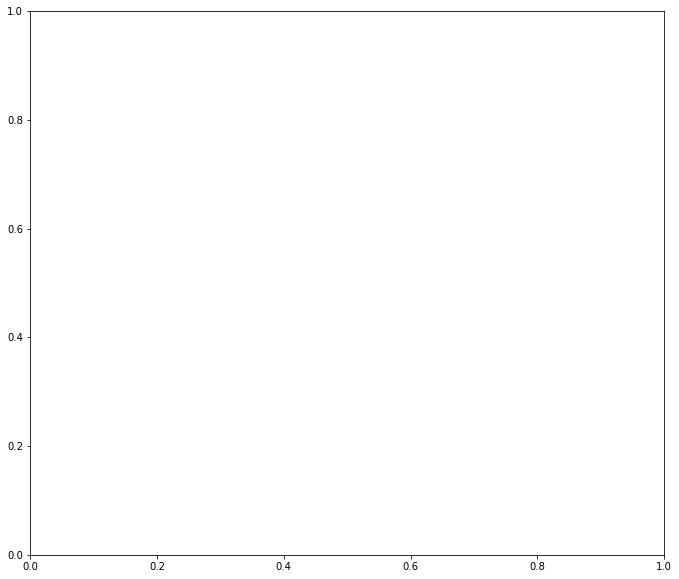

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(25, 10))


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
len(loss)

43

In [ ]:
#denormalize
predyList = [x*rNorm[0,0] for x in y_pred]
testyList = [x*rNorm[0,0] for x in y_test]
#plot result
plt.figure(figsize=(20, 10))
line3, = plt.plot(range(len(predyList)), predyList, alpha = 0.8,label = 'Predicted')
line4, = plt.plot(range(len(testyList)), testyList, label = 'GroundTruth')
plt.ylim(-100,150)
plt.legend([line3,line4],['Predicted','GroundTruth'])
plt.title(' Test & Predicted Cl/Cd Ratio')

In [ ]:
#plot result(zoom in)
plt.figure(figsize=(20,10))
line5, = plt.plot(range(len(predyList)), predyList, alpha = 0.8,label = 'Predicted')
line6, = plt.plot(range(len(testyList)), testyList, label = 'GroundTruth')
plt.ylim(-100,150)
plt.xlim(400,500)
plt.legend([line5,line6],['Predicted','GroundTruth'])
plt.title(' Test & Predicted Cl/Cd Ratio (Zoom In)')

In [ ]:
plt.figure(figsize=(15,10))
pre = [x for x in predyList]
test = [x for x in testyList]
#plt.figure()
plt.scatter(pre, test,s=1)
#plt.scatter(y_pred, y_test,s=1)
plt.plot([-150,150],[-150,150], ls="--",c=".3")
plt.plot([-150,135],[-135,150], ls="--",c=".3")
plt.plot([-135,150],[-150,135], ls="--",c=".3")
plt.xlabel('Predicted Cl/Cd Ratio')
plt.ylabel('Actual Cl/Cd Ratio')
plt.xlim(-50,150)
plt.ylim(-50,150)
plt.title(' Test & Predicted confusion matrix')
plt.show()